# Compressor

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train/255.0
x_test = x_test/255.0

In [3]:
num_values = x_train[0].shape[0] * x_train[0].shape[1]

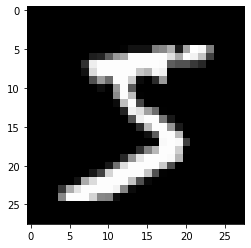

In [4]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0], cmap="gray")

In [5]:
encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')

In [6]:
flat_x = keras.layers.Flatten()(encoder_input)

In [7]:
compress_units = 64
encoder_output = keras.layers.Dense(64, activation="relu")(flat_x)

Metal device set to: Apple M1 Pro


2022-08-14 22:09:54.245791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-14 22:09:54.245908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
print(f'Compressed to {round(100*(compress_units/num_values), 2)}%')

Compressed to 8.16%


In [9]:
encoder = keras.Model(encoder_input, encoder_output, name='model_encoder')

In [10]:
decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)

In [11]:
x = keras.layers.Dense(784, activation="relu")(decoder_input)

In [12]:
decoder_output = keras.layers.Reshape((28, 28, 1))(x)

In [13]:
optimizer_adam = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [14]:
autoencoder = keras.Model(encoder_input, decoder_output, name='model_autoencoder')

In [15]:
autoencoder.summary()

Model: "model_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 105,360
Trainable params: 105,360
Non-trainable params: 0
___________________________________________

In [16]:
autoencoder.compile(optimizer_adam, loss='mse')

In [17]:
epochs=3

for epoch in range(epochs):
    history = autoencoder.fit(x_train, x_train, epochs=1, batch_size=32, validation_split=0.10)
    autoencoder.save(f"../models/ModelAutoEncoder-{epoch+1}.model")

   1/1688 [..............................] - ETA: 5:05 - loss: 0.1202

2022-08-14 22:09:54.658089: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-14 22:09:54.658268: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-14 22:09:54.759190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1686/1688 [============================>.] - ETA: 0s - loss: 0.0224

2022-08-14 22:10:01.476718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1688/1688 [==============================] - 7s 4ms/step - loss: 0.0223 - val_loss: 0.0160
INFO:tensorflow:Assets written to: ../models/ModelAutoEncoder-1.model/assets


2022-08-14 22:10:01.936901: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


1688/1688 [==============================] - 7s 4ms/step - loss: 0.0152 - val_loss: 0.0145
INFO:tensorflow:Assets written to: ../models/ModelAutoEncoder-2.model/assets
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0143 - val_loss: 0.0141
INFO:tensorflow:Assets written to: ../models/ModelAutoEncoder-3.model/assets


2022-08-14 22:10:16.775417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


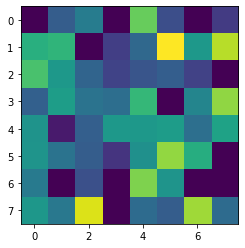

In [18]:
example = encoder.predict([x_test[0].reshape(-1, 28, 28, 1) ])
plt.imshow(example[0].reshape((8,8)))

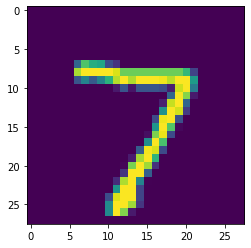

In [19]:
plt.imshow(x_test[0])

2022-08-14 22:10:16.898593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


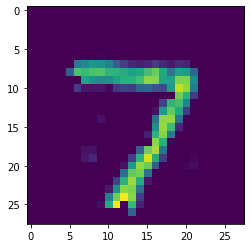

In [20]:
ae_out = autoencoder.predict([x_test[0].reshape(-1, 28, 28, 1) ])
plt.imshow(ae_out[0])